In [59]:

import pynwb
import matplotlib.pyplot as plt
from dandi.dandiapi import DandiAPIClient
import fsspec
import h5py
from fsspec.implementations.cached import CachingFileSystem

In [155]:
dandiset_id = '000402'
session_no = 7
scan_no = 4
filepath = f"sub-17797/sub-17797_ses-{session_no}-scan-{scan_no}_behavior+image+ophys.nwb"

def get_time_series_data(unit_id):

    # Stream file boilerplate
    with DandiAPIClient() as client:
        asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
        s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)
        fs = fsspec.filesystem("http")
        fs = CachingFileSystem(
            fs=fs,
            cache_storage="nwb-cache",
        )
        with fs.open(s3_url, "rb") as f:
            with h5py.File(f) as file:
                with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
                    nwbfile = io.read()
                    # display(nwbfile)

                    # Iterate through plane segmentation tables and find the mask id and table number of the unit id
                    for plane_seg in range(1, 9):
                        image_seg = nwbfile.processing["ophys"].data_interfaces["ImageSegmentation"].plane_segmentations[f"PlaneSegmentation{plane_seg}"]
                        # placeholder column will be populated by danny
                        image_seg.add_column(data=[plane_seg*10*i for i in range(len(image_seg))], name="unit_id", description="placeholder for danny's column")
                        try:
                            mask_id = image_seg.get("unit_id").data.index(unit_id)
                        except:
                            continue
                        else:
                            break

                    # Get fluorescence of the table number
                    fluor = nwbfile.processing["ophys"].data_interfaces["Fluorescence"].roi_response_series[f"RoiResponseSeries{plane_seg}"]

                    # Pull the data we are interested in
                    mask_image = image_seg.image_mask[mask_id]
                    fluor_data = fluor.data[:, mask_id]
                    timestamps = fluor.timestamps[:]

                    return mask_image, fluor_data, timestamps

unit_id = 18400
mask_image, fluor, timestamps = get_time_series_data(unit_id)

Text(0, 0.5, 'response magnitude')

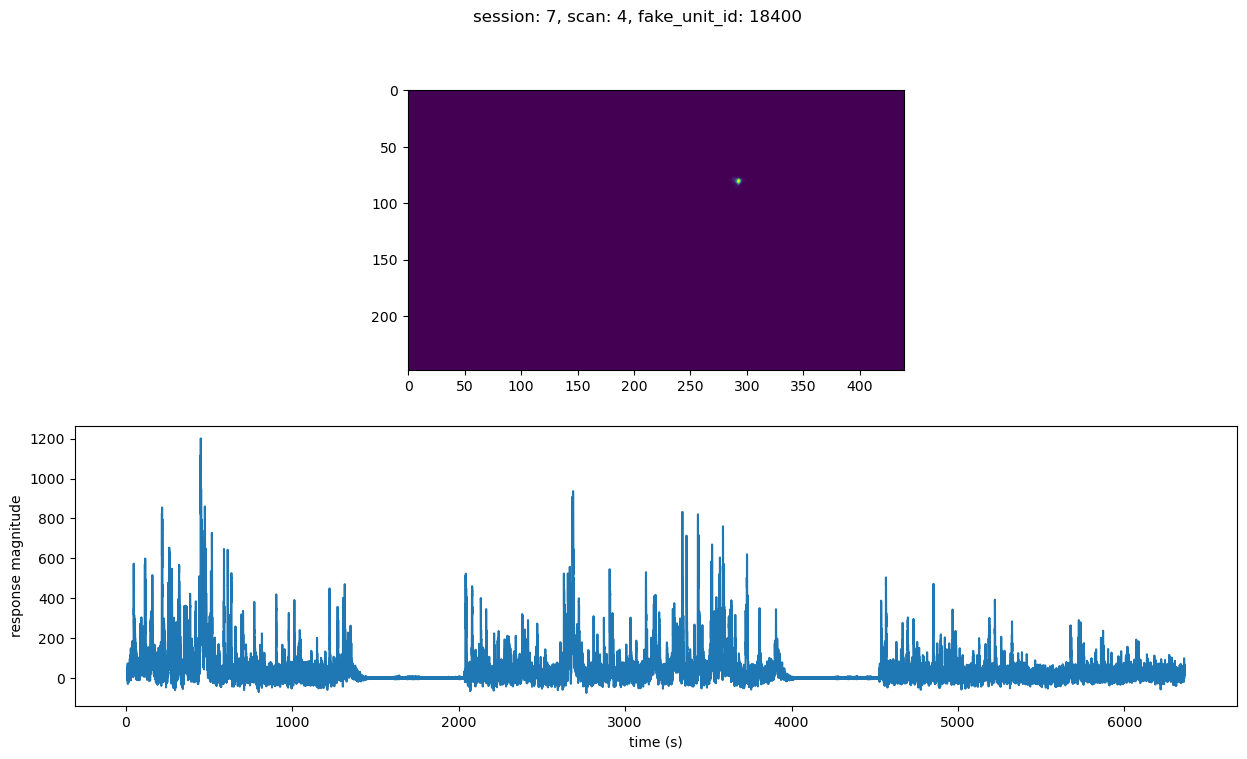

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
fig.suptitle(f'session: {session_no}, scan: {scan_no}, fake_unit_id: {unit_id}')
ax1.imshow(mask_image)
ax2.plot(timestamps, fluor)
ax2.set_xlabel("time (s)")
ax2.set_ylabel("response magnitude")